## Define Function for reading in xy or xz plane slices

Reading /Users/atcushen/Documents/SWMF/inv2/run4/GMPC-ta-3-test/box_var_2_t00000150_n00602152.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7605
Connection established.


AttributeError: 'OrderedZone' object has no attribute 'variable_names'

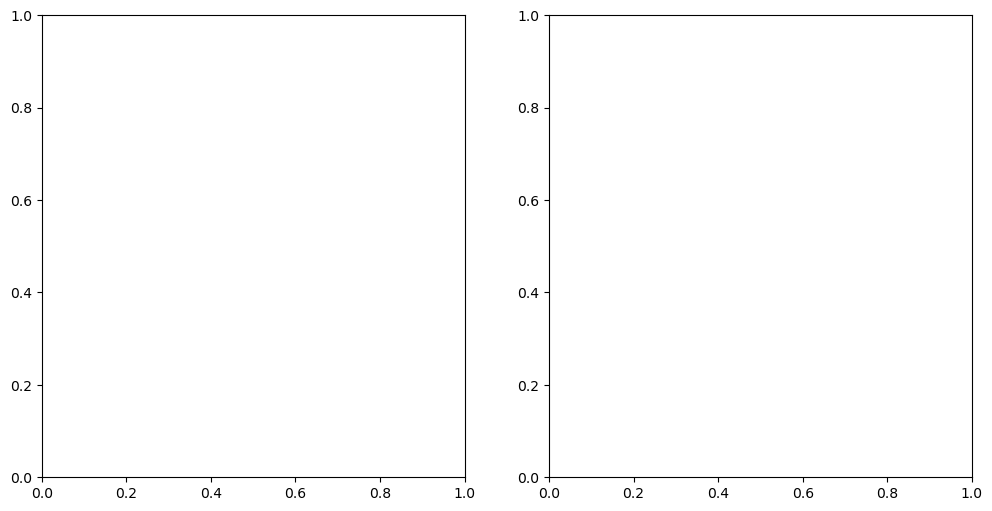

In [12]:
# Efficient module for generating movies from 2D tecplot.
# Make sure pytecplot connection is exposed!!

# import modules
from os import listdir
from os.path import isfile, join
import re
import tecplot as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import LogNorm
from tecplot.exception import *
from tecplot.constant import *
import matplotlib.animation as animation
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl

# Define constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m

# Define data extraction function
def extract_2d_grid(mypath,var_ls=["Rho*"],plane="xy",shape=[20,20],xlims=[-2.5,2.5],ylims=[-2.5,2.5]):
    # Loads file "mypath"
    # Slices along "plane" (either xy at z=0.2 or xz at y=0)
    # Extracts interpolated 2d meshgrid with size "shape" within bounds (xmin,xmax) (ymin,ymax)
    # Returns a dictionary of 2d meshgrids for each var in var_ls

    # Note: y is used to refer to the "vertical" coordinate, which could be Y or X
    print("Reading",mypath)
    # Connect to tp and load data
    tp.session.connect(port=7605)
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    plot = frame.plot(PlotType.Cartesian2D)
    plot.axes.x_axis.variable_index=2

    # Define meshgrid params
    nx = shape[0]
    ny = shape[1]
    xmin,xmax = xlims
    ymin,ymax = ylims
    
    # Generate meshgrids
    x = np.linspace(xmin, xmax, nx)
    y = np.linspace(ymin, ymax, ny)
    tp.active_frame().plot().axes.x_axis.variable_index=2
    if plane=="xy":
        xx, yy = np.meshgrid(x, y)
        zz = 0.2+np.zeros_like(xx)
        plot.axes.y_axis.variable_index=3 # Assign the vertical axis to y
    elif plane=="xz":
        xx, zz = np.meshgrid(x, y)
        yy = np.zeros_like(xx)
        plot.axes.y_axis.variable_index=4 # Assign the vertical axis to z
    else: 
        print("ERROR: bad slice plane!")
        return None

    # Perform needed calculations within tp
    tp.data.operate.execute_equation(equation='{Bmag} = sqrt({B_x [nT]}**2+{B_y [nT]}**2+{B_z [nT]}**2)',
        ignore_divide_by_zero=True)
    #tp.data.operate.execute_equation(equation='{dB_ZdX}=ddx({B_z [nT]})',
    #    ignore_divide_by_zero=True)

    # Define zone to interpolate to
    rect_zone = dataset.add_ordered_zone('current_sheet',shape)

    rect_zone.values('X*')[:] = xx.ravel()
    rect_zone.values('Y*')[:] = yy.ravel()
    rect_zone.values('Z*')[:] = zz.ravel()
    
    X_seed = rect_zone.values('X*')
    Y_seed = rect_zone.values('Y*')
    Z_seed = rect_zone.values('Z*')

    # Interpolate each param of interest; see previous code block for more explicit example
    out_dict={}
    for var in var_ls:
        #tp.data.operate.interpolate_linear(rect_zone, dataset.zone('STRUCTURED*'), dataset.variable(var))
        tp.data.operate.interpolate_linear(source_zones=[0],destination_zone=1,variables=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])
        print(rect_zone.variable_names)
        temp = rect_zone.values(var).as_numpy_array() 
        out = np.zeros_like(xx)
        count=0
        for j in range(ny):
            for i in range(nx):
                out[-j,-i] = temp[-count]
                count+=1
        out_dict[var]=out

    return out_dict, xx, yy, zz

# show test use and example plots
xlims=[-3,3]
ylims=[-3,3]
shape=[150,150]

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6*2,6))

filename = '/Users/atcushen/Documents/SWMF/inv2/run4/GMPC-ta-3-test/box_var_2_t00000150_n00602152.plt'
my_data,xx,yy,zz = extract_2d_grid(filename,var_ls=["Rho*","B_x*","B_z*"],shape=shape,xlims=xlims,ylims=ylims,plane="xz")
im=axs[0].imshow(my_data["Rho*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=1, vmax=150), origin='lower')
axs[0].streamplot(xx,zz,my_data["B_x*"],my_data["B_z*"],color='white',linewidth=0.5,broken_streamlines=False,arrowsize=0.5)
axs[0].set_title("xz plane (Magnetic field lines)")
axs[0].add_patch(plt.Circle((0, 0), 1, color='grey'))
axs[0].add_patch(plt.Circle((0, 0), 0.8, color='black'))
axs[0].set_xlim(xlims)
axs[0].set_ylim(xlims)

filename = '/Users/atcushen/Documents/SWMF/inv2/run4/GMPC-ta-3-test/box_var_1_t00000150_n00602152.plt'
my_data,xx,yy,zz = extract_2d_grid(filename,var_ls=["Rho*","U_x*","U_y*"],shape=shape,xlims=xlims,ylims=ylims,plane="xy")
im=axs[1].imshow(my_data["Rho*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=1, vmax=150), origin='lower')
axs[1].streamplot(xx,yy,my_data["U_x*"],my_data["U_y*"],color='white',linewidth=0.5,density=2,arrowsize=0.5)
axs[1].set_title("xy plane (Bulk flow lines)")
axs[1].add_patch(plt.Circle((0, 0), 1, color='grey'))
axs[1].add_patch(plt.Circle((0, 0), 0.8, color='black'))
axs[1].set_xlim(xlims)
axs[1].set_ylim(xlims)

#clb=fig.colorbar(im,ax=axs[2])
#clb.ax.set_title('$rho$ [amu/cc]',fontsize=12)


## Loop this function and save the results as individual frames

In [28]:
# Generate movies

#########################

# High-level user input
folder = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-5_rerun"    # Folder with data (without "/" at the end)
#start_time = 0                                                # What is the start time of the dataset?
t_bound = [55,117]                                               # Start and stop times for the GIF
vars_to_plot = ["Rho*","B_z*","U_x*","U_y*","B_y*","B_x*","P*","J_x*","J_y*","J_z*"]       # What native variable to plot
dt = 1.0                                                      # What is the timestep between files?
slice = "xz"                                                   # Set plane of slice ("xy" or "xz")
use_3d = True     # Set to True if we are using 3d__ files

# Choose plot type from existing presets;
# "xz_field": overview plot of rho and field lines for making movies.
# Recommended settings:
#xlims=[-5,4]
#ylims=[-4.5,4.5]
#shape=[160,160]

# "dipolarization_zoom": bz and field lines to show particular dipolarization event in detail
# Recommended settings:
# xlims=[-2.2,0.2]
# ylims=[-1.2,1.2]
# shape=[160,160]

# "dipolarization_superzoom": plasma temp for even more zoomed region in xy plane
# Recommended settings:
# xlims=[-2.0,-0.5]
# ylims=[-1.0,1.0]
# shape=[160,160]

# "E_y":  flow vectors and duskward convective field
#xlims=[-2.2,0.2]
#ylims=[-1.2,1.2]
#shape=[160,160]

# "xy_flow": overview plot of rho and field lines for making movies.
# Recommended settings:
#xlims=[-5,4]
#ylims=[-4.5,4.5]
#shape=[160,160]

# "xz_tail": plot of pressure and field lines for making movies of dipolarization
# Recommended settings:
#xlims=[-8,2]
#ylims=[-2,2]
#shape=[220,110]

plot_preset = "xz_field"

# Grid settings
xlims=[-5,4]
ylims=[-4.5,4.5]
shape=[220,220]

#########################

# First, get list of files in directory
dir=str(folder+"/")
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]

# Then use regex to pick out only the files we want 
files=[]
for file in all_files:
    if slice == "xy":
        if use_3d:
            match = re.search("^3d__var.*",file)
        else:
            match = re.search("^box_var_3_.*",file)
        if match != None:
            files.append(file)
    elif slice == "xz":
        if use_3d:
            match = re.search("^3d__var.*",file)
        else:
            match = re.search("^box_var_4_.*",file)
        if match != None:
            files.append(file)
    else:
        print("ERROR: bad slice plane!")
files.sort()
files = files
print(str(len(files)),"files recognized!")

# Make a dictionary with better names for the files:
named_files = {}
start_min = int(re.search(".*\_t(..)..\....\.plt",files[0])[1])
start_sec = int(re.search(".*\_t..(..)\....\.plt",files[0])[1])
start_millisec = int(re.search(".*\_t....\.(...)\.plt",files[0])[1])
start_time = 60.0*start_min + start_sec + 0.001*start_millisec
print("start time",start_time)
for i in range(len(files)):
    time = round(i*dt+start_time,3)
    named_files[time] = files[i]

# Loop over each file, pull the data, make the plots, and save as .pngs in /frames
last_time = -1.0
for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
    filename = str(dir+named_files[time])

    # Get data from file
    mydata,xx,yy,zz = extract_2d_grid(filename,var_ls=vars_to_plot,shape=shape,xlims=xlims,ylims=ylims,plane=slice)

    # Do data manipulation here (NEEDS TO BE UPDATED TO USE xx,yy,zz AND WORK FOR BOTH XY and XZ
    ###########
    #x = np.linspace(xlims[0], xlims[1], shape[0])
    #y = np.linspace(ylims[0], ylims[1], shape[1])
    #xv, yv = np.meshgrid(x, y)

    #B_mag = np.sqrt(mydata["B_x*"]**2+mydata["B_y*"]**2+mydata["B_z*"]**2) # Field magnitude
    #beta = mydata["P*"]*1e-9 / ((B_mag*1e-9)**2/(2*mu_0))
    E_y = mydata["U_x*"] * mydata["B_z*"]* 1e3 * 1e-9 # vxB
    J = np.sqrt(mydata["J_x*"]**2+mydata["J_y*"]**2+mydata["J_z*"]**2)  # mA/m^2
    #T = mydata["P*"] * 1e9 / (mydata["Rho*"]*1e6 * k_b)
    T = np.divide(mydata["P*"], mydata["Rho*"], out=np.zeros_like(mydata["P*"]), where=mydata["Rho*"]!=0) * 1e-9 / 1e6 / k_b
    ###########
    
    # Plot!!
    fig, ax = plt.subplots(figsize=(10,10))
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')

    # Use preset
    if plot_preset == "E_y":
        im=ax.imshow(E_y*1e3, cmap='bwr', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]], origin="lower")
        clb=fig.colorbar(im)
        im.set_clim(-50,50)
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$E_y$ [mV/m]',fontsize=12)
        #ax.contour(xv, yv, mydata["B_z*"], [0],colors='yellow')
        quiver_skip=10
        ax.quiver(xx[::quiver_skip,::quiver_skip], yy[::quiver_skip,::quiver_skip],mydata["U_x*"][::quiver_skip,::quiver_skip], mydata["U_y*"][::quiver_skip,::quiver_skip],color="white")
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Convection field and velocity at t="+str(round(time,2))+"s"))

    elif plot_preset == "dB_dx":
        im=ax.imshow(mydata["dB*"], cmap='viridis', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]])
        clb=fig.colorbar(im)
        im.set_clim(-100,300)
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$dB_z/dx$ [nT/$R_M$]',fontsize=12)
        ax.contour(xv, yv, mydata["B_z*"], [0,20,40,60,80,100,120], colors='white')
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.set_title(str("Magnetic field gradient at t="+str(round(time,2))+"s"))

    elif plot_preset == "B_z":
        im=ax.imshow(mydata["B_z*"], cmap='bwr', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]])
        clb=fig.colorbar(im)
        im.set_clim(-50,50)
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$dB_z$ [nT]',fontsize=12)
        #ax.contour(xv, yv, mydata["B_z*"], [0,20,40,60,80,100,120], colors='white')
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.set_title(str("Magnetic field at t="+str(round(time,2))+"s"))
        ax.add_patch(outer)
        ax.add_patch(inner)

    elif plot_preset == "DF":
        im=ax.imshow(mydata["dB*"], cmap='viridis', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]])
        clb=fig.colorbar(im)
        im.set_clim(-100,300)
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$dB_z/dx$ [nT/$R_M$]',fontsize=12)
        ax.contour(xv, yv, beta, [0.95,1,1.05], colors='white')
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.set_title(str("Magnetic field gradient at t="+str(round(time,2))+"s"))

    elif plot_preset == "U_x":
        im=ax.imshow(mydata["U_x*"], cmap='rainbow', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]])
        clb=fig.colorbar(im)
        im.set_clim(-600,600)
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$Velocity$ [km/s]',fontsize=12)
        ax.contour(xv, yv, mydata["B_z*"], [0],colors='yellow')
        ax.quiver(xv[::10,::10], yv[::10,::10], mydata["U_x*"][::10,::10], mydata["U_y*"][::10,::10])
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.set_title(str("$U_x$ at t="+str(round(time,2))+"s"))
    
    elif plot_preset == "xz_field":
        #Define streamtrace start points
        start_points = np.zeros([80,2])
        start_points[:40,0]=1.02*np.cos(np.linspace(0,2*np.pi,40))
        start_points[:40,1]=1.02*np.sin(np.linspace(0,2*np.pi,40))
        start_points[40:50,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[40:50,1] = ylims[0]
        start_points[50:60,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[50:60,1] = ylims[1]
        start_points[60:70,0] = xlims[0]
        start_points[60:70,1] = np.linspace(ylims[0],ylims[1],10)
        start_points[70:,0] = np.linspace(-5,-2,10)
        start_points[70:,1] = 0.2
        
        im=ax.imshow(mydata["Rho*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=1, vmax=120), origin='lower')
        ax.streamplot(xx,zz,mydata["B_x*"],mydata["B_z*"],color='white',linewidth=0.5,broken_streamlines=False,arrowsize=0.5,
                      start_points=start_points)
        ax.plot([-3.5,0,0,-3.5,-3.5],[-0.3,-0.3,0.7,0.7,-0.3],linestyle="dashed",color="grey",linewidth=1.5,alpha=0.8) # show pic box
        clb=fig.colorbar(im)
        clb.ax.tick_params(labelsize=8) 
        clb.ax.set_title('rho [amu/cc]',fontsize=12)
        ax.set_title(str("Density at t="+str(round(time,2))+"s"))
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect(1)
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")

    elif plot_preset == "xz_tail":
        fig, ax = plt.subplots(figsize=(16,8))
        #Define streamtrace start points
        start_points = np.zeros([90,2])
        start_points[:40,0]=1.02*np.cos(np.linspace(0,2*np.pi,40))
        start_points[:40,1]=1.02*np.sin(np.linspace(0,2*np.pi,40))
        start_points[40:50,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[40:50,1] = ylims[0]
        start_points[50:60,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[50:60,1] = ylims[1]
        start_points[60:70,0] = xlims[0]
        start_points[60:70,1] = np.linspace(ylims[0],ylims[1],10)
        start_points[70:80,0] = np.linspace(-4,-2.0,10) # current sheet
        start_points[70:80,1] = np.linspace(0.55,0.3,10) 
        start_points[80:,0] = -1.1 # dipolarization region
        start_points[80:,1] = np.linspace(0,0.2,10)
        
        im=ax.imshow(mydata["P*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=0.01, vmax=20), origin='lower')
        ax.streamplot(xx,zz,mydata["B_x*"],mydata["B_z*"],color='white',linewidth=0.5,broken_streamlines=False,arrowsize=0.5,
                      start_points=start_points)
        #Draw pic box
        #ax.plot([-3.5,0,0,-3.5,-3.5],[-0.3,-0.3,0.7,0.7,-0.3],linestyle="dashed",color="grey",linewidth=1.5,alpha=0.8) # show pic box
        
        clb=fig.colorbar(im)
        clb.ax.tick_params(labelsize=8) 
        clb.ax.set_title('P [nPa]',fontsize=12)
        ax.set_title(str("Pressure at t="+str(round(time,2))+"s"))
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect(1)
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")

    elif plot_preset == "dipolarization_zoom":
        #Define streamtrace start points
        start_points = np.zeros([70,2])
        start_points[:40,0]=1.02*np.cos(np.linspace(np.pi/2,3*np.pi/2,40))
        start_points[:40,1]=1.02*np.sin(np.linspace(np.pi/2,3*np.pi/2,40))
        start_points[40:50,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[40:50,1] = ylims[0]
        start_points[50:60,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[50:60,1] = ylims[1]
        start_points[60:,0] = np.linspace(ylims[0],-1,10)
        start_points[60:,1] = 0.2
        
        im=ax.imshow(mydata["B_z*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]],cmap='bwr', origin='lower')
        ax.streamplot(xx,zz,mydata["B_x*"],mydata["B_z*"],color='black',linewidth=0.5,broken_streamlines=False,arrowsize=0.5,
                      start_points=start_points)
        ax.set_title(str("Magnetic field at t="+str(round(time,2))+"s"))
        clb=fig.colorbar(im)
        clb.ax.tick_params(labelsize=8) 
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        im.set_clim(-80,80)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect(1)
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")

    elif plot_preset == "dipolarization_superzoom":
        #Define streamtrace start points
        im2=ax.imshow(mydata["B_z*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]], origin='lower',)
        im=ax.imshow(T,extent=[xlims[0], xlims[1],ylims[0], ylims[1]],cmap='rainbow', origin='lower', norm=LogNorm(vmin=1e6, vmax=1e9))
        ax.set_title(str("Plasma temperature at t="+str(round(time,2))+"s"))
        cont=ax.contour(xx, yy, mydata["B_z*"], np.linspace(20,100,21),linewidths=0.8)
        clb1=fig.colorbar(im)
        clb2=fig.colorbar(im2)
        clb1.ax.tick_params(labelsize=8) 
        clb1.ax.tick_params(labelsize=8) 
        clb1.ax.set_title('T [K]',fontsize=12)
        clb2.ax.set_title('$B_Z$ [nT]',fontsize=12)
        #im.set_clim(1e7,1e8)
        im2.set_clim(20,100)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect(1)
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")

    elif plot_preset == "xy_current":
        start_points = np.zeros([5,2])
        start_points[:,0]=np.linspace(-2.25,-1.25,5)
        start_points[:,1]=0
        
        im=ax.imshow(J,extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=0.01, vmax=0.8),cmap='viridis', origin='lower')
        quiver_skip=5
        ax.quiver(xv[::quiver_skip,::quiver_skip], yv[::quiver_skip,::quiver_skip],
                  mydata["J_x*"][::quiver_skip,::quiver_skip], mydata["J_y*"][::quiver_skip,::quiver_skip],
                  color="white",scale=5,minlength=0.6)
        ax.streamplot(xx,yy,mydata["J_x*"],mydata["B_y*"],color='white',linewidth=0.8,broken_streamlines=False,arrowsize=0.7,
                      start_points=start_points)
        ax.set_title(str("Current at t="+str(round(time,2))+"s"))
        clb=fig.colorbar(im)
        clb.ax.tick_params(labelsize=8) 
        clb.ax.set_title('Current [mA/m$^2]',fontsize=12)
        #im.set_clim(-80,80)
        ax.add_patch(outer,zorder=2)
        ax.add_patch(inner,zorder=2)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect(1)
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")

    else: 
        im=ax.imshow(mydata["Rho*"], cmap='bwr', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=1, vmax=150))
        clb=fig.colorbar(im)
        clb.ax.tick_params(labelsize=8) 
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        #ax.contour(xv, yv, mydata["U_x*"], [0],colors='white')
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.set_title(str("Density at t="+str(round(time,2))+"s"))

    # Save
    fig.savefig(str(folder+"_plots/"+plot_preset+"_"+str(round(time,2))+'.png'),bbox_inches='tight')
    #plt.show()
    plt.close(fig)

print("last file read:",filename)



23 files recognized!
start time 55.0
Reading /Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-5_rerun/3d__var_2_t0055.000.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.


TecplotSystemError: No part of the destination zone was inside of the source zone(s).

## Convert to GIF

In [4]:
# Generate GIF from frames

import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

print("running...")

#read all the .png files in directory "frames"
#dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e_plots/"
dir = "/Volumes/My Book Duo/runs/nightside_v5_run2/ta-2_plots/"
files = glob.glob(str(dir+"Jy*.png"))
image_array = []
files=natsorted(files)

for my_file in files:
    image = Image.open(my_file)
    image_array.append(image)
    
# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(8, 8))

# Set the initial image
im = ax.imshow(image_array[0], animated=True)
plt.axis('off')

def update(i):
    im.set_array(image_array[i])
    return im, 

# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)

# Show the animation
#plt.show()

animation_fig.save(str(dir+"animated1.gif"),dpi=500)
plt.close(fig)
print("Done!")

running...
Done!


## Compute $\delta B$

In [2]:
# New challenge: Compute dB, the perturbation field, using same approach as Dewey 2020:
# Basically, for some point (x,y), we subtract the average B_Z in that cell from -20<t<-10s
# The plan is to first accept input for the time range to be computed (e.g. t=25 to t=28s) and cadence (0.1s default).
# Then, all the B_z values from 5-18 s will be loaded and saved to arrays
# For each desired plot time, we then loop over the arrays to compute the average for each cell.
# There is probably a more numerically efficient way to do this, but I can't think of it.

# import modules
from os import listdir
from os.path import isfile, join
import re
import tecplot as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import LogNorm
from tecplot.exception import *
from tecplot.constant import *
import matplotlib.animation as animation
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl


# Set start and end times of output
t_bound = [20,23]
dt = 0.2

# Directory of files
folder = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-2"
start_time = 0 # earliest time in the directory

# Grid settings
xlims=[-2,-0.8]#[-2,0]
ylims=[-0.8,0.8]#[-1.5,1.5]
shape=[300,400]#[300,450]

#########################

# First, get list of files in directory
dir=str(folder+"/")
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]

# Then use regex to pick out only the files we want 
files=[]
for file in all_files:
    match = re.search("^box_var_3_.*",file)
    if match != None:
        files.append(file)
files.sort()        
print(str(len(files)),"files recognized!")

# Make a dictionary with better names for the files:
named_files = {}
for i in range(len(files)):
    time = round(i*dt+start_time,3)
    named_files[time] = files[i]

# Now, import the needed data as numpy arrays and save to a dictionary
bz_data = {}
for n in range(int((t_bound[1]-10-(t_bound[0]-20))/dt+1)):
    time = round(t_bound[0]-20+dt*n,3)
    # Use extract_2d_grid() to pull the datasets
    filename = str(dir+str(named_files[time]))
    bz_data[time] = extract_2d_grid(filename,var_ls=["B_z*"],shape=shape,xlims=xlims,ylims=ylims)[0]["B_z*"]
    # Note that extract_2d_grid returns a dictionary; we just need the B_z item.

print(str(n),"files read!")

118 files recognized!
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Serv

In [3]:
# Now, just the files we need are saved in bz_data. Now, we loop over the desired output times and compute the average values
output = {}
for n in range(int((t_bound[1]-(t_bound[0]))/dt+1)):
    # First, load the actual B_z data for the output time (e.g. t=25s)
    time = round(t_bound[0]+dt*n,3)
    filename = str(dir+str(named_files[time]))
    data,xx,yy,zz = extract_2d_grid(filename,var_ls=["B_z*","U_x*"],shape=shape,xlims=xlims,ylims=ylims)
    output[time] = data["B_z*"]
    
    # Then, loop over the 10s range to compute the avg.
    bz_avg = np.zeros_like(output[time])
    for m in range(0,int(10/dt)+1):
        avg_time = round(time-20+dt*m,3)
        #print(avg_time)
        bz_avg += bz_data[avg_time]
    bz_avg = bz_avg/(10/dt+1)

    # Subtract average
    output[time] = output[time] - bz_avg

    # Plot!
    fig, ax = plt.subplots(figsize=(6,6))
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')
    im=ax.imshow(output[time], cmap='coolwarm', interpolation='none', 
                 extent=[xlims[0], xlims[1], ylims[0], ylims[1]], origin='lower')
    #ax.contour(xx, yy, data["U_x*"], [0],colors='white')
    ax.contour(xx, yy, data["B_z*"], [0],colors='white')
    clb=fig.colorbar(im)
    im.set_clim(-10,10)
    clb.ax.tick_params(labelsize=8)
    clb.ax.set_title('$\delta B_z$ [nT]',fontsize=12)
    #ax.contour(xv, yv, mydata["B_z*"], [0],colors='yellow')
    #quiver_skip=20
    #ax.quiver(xv[::quiver_skip,::quiver_skip], yv[::quiver_skip,::quiver_skip], 
    #          mydata["U_x*"][::quiver_skip,::quiver_skip], mydata["U_y*"][::quiver_skip,::quiver_skip],color="white")
    ax.set_aspect(1) # 
    ax.set_xlabel("X [$R_M$]")
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    ax.set_ylabel("Y [$R_M$]")
    ax.set_title(str("Perturbed $B_z$ at t="+str(time)+"s"))
    ax.add_patch(outer)
    ax.add_patch(inner)

    # Save
    fig.savefig(str(folder+"_plots/"+"deltaB_"+str(round(time,2))+'.png'),bbox_inches='tight')
    #plt.show()
    plt.close(fig)

Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://local

running...


IndexError: list index out of range

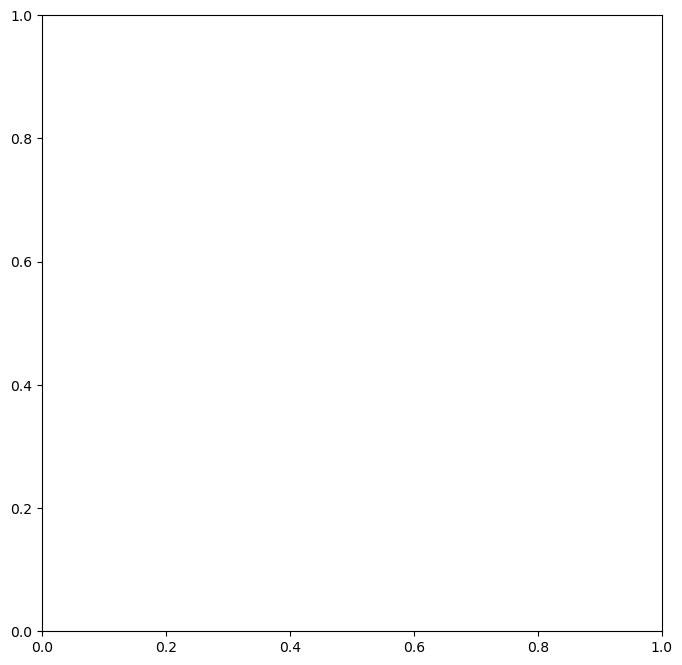

In [2]:
# Generate GIF from frames

import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

print("running...")

#read all the .png files in directory "frames"
files = glob.glob(r"pic_E_y/*.png")
image_array = []
files=natsorted(files)

for my_file in files:
    image = Image.open(my_file)
    image_array.append(image)
    
# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(8, 8))

# Set the initial image
im = ax.imshow(image_array[0], animated=True)
plt.axis('off')

def update(i):
    im.set_array(image_array[i])
    return im, 

# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=1000, blit=True,repeat_delay=10,)

# Show the animation
#plt.show()

animation_fig.save("pic_E_y/animated.gif")
plt.close(fig)

## Entropy calc

In [10]:
# Now, to speed up entropy calculation, we want to halt if a streamtrace isnt closed...

# Loop entropy calculation over multiple files

# Import modules
import tecplot as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import LogNorm
from tecplot.exception import *
from tecplot.constant import *


# Define constants
R_M = 2440e3 #m


# Define grid / data variables
start_time = 153                                                # What is the start time of the dataset?
t_bound = [153,158]  
n_time = 5
dt = 1
dir = "/Users/atcushen/Documents/SWMF/inv2/run4/GMPC-ta-4/"    # Directory with data 

# First, get list of files in directory
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]

# Then use regex to pick out only the files we want 
files=[]
for file in all_files:
    match = re.search("^3d__var_4_.*",file)
    if match != None:
        files.append(file)
files.sort()
files = files
print(str(len(files)),"files recognized!")

# Make a dictionary with better names for the files:
named_files = {}
for i in range(len(files)):
    time = round(i*dt+start_time,3)
    named_files[time] = files[i]

# Loop over each file, pull the data, make the plots, and save as .pngs in /frames
last_time = -1.0
iter=0
results=[]
for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
    print("time:",time)
    filename = str(dir+named_files[time])
    z_plane = 0.2
    x_min = -2
    x_max = -0.8
    y_min = -0.8
    y_max = 0.8
    nx = 60
    ny = 80
    
    
    # Generate meshgrid
    x = np.linspace(x_min, x_max, nx)
    y = np.linspace(y_min, y_max, ny)
    xv, yv = np.meshgrid(x, y)
    zv = z_plane+np.zeros_like(xv)
    
    # Load file and define vector for streamtrace
    tp.session.connect()
    tp.new_layout()
    dataset = tp.data.load_tecplot(filename)
    frame = tp.active_frame()
    plot = frame.plot(PlotType.Cartesian3D)
    plot.vector.u_variable_index=10
    plot.vector.v_variable_index=11
    plot.vector.w_variable_index=12
    
    
    # Define entropy
    tp.data.operate.execute_equation(equation='{gamma} = 5/3',
        ignore_divide_by_zero=True)
    tp.data.operate.execute_equation(equation='{Bmag} = sqrt({B_x [nT]}**2+{B_y [nT]}**2+{B_z [nT]}**2)',
        ignore_divide_by_zero=True)
    tp.data.operate.execute_equation(equation='{entropy}=({P [nPa]}*10**(-9))**(1/{gamma})/({Bmag}*10**(-9))',
        ignore_divide_by_zero=True)
    
    # Pull out x-velocity and interpolate onto grid
    #v_x = dataset.variable('U_x*')
    shape = (nx,ny)
    
    rect_zone = dataset.add_ordered_zone('current_sheet',shape)
        
    rect_zone.values('X*')[:] = xv.ravel()
    rect_zone.values('Y*')[:] = yv.ravel()
    rect_zone.values('Z*')[:] = zv.ravel()
    
    X_seed = rect_zone.values('X*')
    Y_seed = rect_zone.values('Y*')
    Z_seed = rect_zone.values('Z*')
    
    tp.data.operate.interpolate_linear(rect_zone, dataset.zone('3D*'), dataset.variable('U_x*'))
    tp.data.operate.interpolate_linear(rect_zone, dataset.zone('3D*'), dataset.variable('B_z*'))
    u_x_shapeless = rect_zone.values('U_x*').as_numpy_array() #unfortunately, it is unstructed, so we need to force into the right shape
    b_z_shapeless = rect_zone.values('B_z*').as_numpy_array() 
    u_x = np.zeros_like(xv)
    b_z = np.zeros_like(xv)
    count=0
    for j in range(ny):
        for i in range(nx):
            u_x[-j,-i] = u_x_shapeless[-count]
            b_z[-j,-i] = b_z_shapeless[-count]
            count+=1
    
    # Loop over each grid point:
    H = np.zeros_like(xv)
    index = dataset.variable('entrop*').index+1 # get index for entropy data, add one since it uses 1-based indexing
    zone = 3 # Zone1 is data, zone2 is current_sheet
    with tp.session.suspend():    
        for i in range(nx):
            for j in range(ny): # j is row (y), i is column (x)
                plot.streamtraces.delete_all()
                if (xv[j,i]**2+yv[j,i]**2)>1.0:
                    #print("Meshgrid coord [",j,",",i,"] and real coord (",xv[j,i],",",yv[j,i])
                    plot.streamtraces.add(seed_point=[xv[j,i], yv[j,i], z_plane],stream_type=Streamtrace.VolumeLine)
                    plot.streamtraces.extract()
                    
                    #ONLY PROCEED TO INTEGRATION IF STREAMLINE IS CLOSED: (i use zone-1 since zone=3 is for 1 based index, and this needs 0 based)
                    streamline_max = np.sqrt(dataset.zone(int(zone-1)).values("X*").max()**2+dataset.zone(zone-1).values("Y*").max()**2+dataset.zone(zone-1).values("Z*").max()**2)
                    streamline_min = np.sqrt(dataset.zone(int(zone-1)).values("X*").min()**2+dataset.zone(zone-1).values("Y*").min()**2+dataset.zone(zone-1).values("Z*").min()**2)

                    #Closed field lines
                    if streamline_max<100 and streamline_min<100:
                        tp.macro.execute_extended_command(command_processor_id='CFDAnalyzer4',
                                command=str("Integrate ["+str(zone)+"] VariableOption='Scalar' XOrigin=0 YOrigin=0 ZOrigin=0 ScalarVar="+str(4)+" Absolute='F' ExcludeBlanked='F' XVariable=1 YVariable=2 ZVariable=3 IntegrateOver='Cells' IntegrateBy='Zones' IRange={MIN =1 MAX = 0 SKIP = 1} JRange={MIN =1 MAX = 0 SKIP = 1} KRange={MIN =1 MAX = 0 SKIP = 1} PlotResults='F' PlotAs='Result' TimeMin=0 TimeMax=0"))
                        H[j,i] = tp.active_frame().aux_data['CFDA.INTEGRATION_TOTAL']
                    #Open/closed 
                    elif streamline_max<100 or streamline_max<100:
                        H[j,i] = 10/R_M
                    #Open
                    else:
                        H[j,i] = 1000/R_M
                    zone+=1
                    if zone%10==0:
                        print(time, zone, end =" ")
    print("done!")
    #Move into physical units
    H = H*R_M
    
    #Plot
    fig, axs = plt.subplots(figsize=(10,10))
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')
    im=axs.imshow(H, cmap='rainbow', interpolation='none', extent=[x_min,x_max,y_min,y_max], 
                  origin='lower', norm=LogNorm(vmin=10, vmax=1e8))
    axs.contour(xv, yv, u_x, [0],colors='yellow')
    axs.contour(xv, yv, b_z, [0],colors='white')
    clb=fig.colorbar(im)
    im.set_clim(1e6,6e7)
    clb.ax.tick_params(labelsize=8) 
    clb.ax.set_title('$H$ [unit]',fontsize=12)
    axs.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    axs.set_xlabel("X [$R_M$]")
    axs.set_ylabel("Y [$R_M$]")
    axs.set_title(str("Flux tube entropy at t="+str(time)+"s"))

    fig.savefig(str("entropy/"+str(round(time,2))+'.png'),bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    iter+=1

5 files recognized!
time: 153
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
153 10 153 20 153 30 153 40 153 50 153 60 153 70 153 80 153 90 153 100 153 110 153 120 153 130 153 140 153 150 153 160 153 170 153 180 153 190 153 200 153 210 153 220 153 230 153 240 153 250 153 260 153 270 153 280 153 290 153 300 153 310 153 320 153 330 153 340 153 350 153 360 153 370 153 380 153 390 153 400 153 410 153 420 153 430 153 440 153 450 153 460 153 470 153 480 153 490 153 500 153 510 153 520 153 530 153 540 153 550 153 560 153 570 153 580 153 590 153 600 153 610 153 620 153 630 153 640 153 650 153 660 153 670 153 680 153 690 153 700 153 710 153 720 153 730 153 740 153 750 153 760 153 770 153 780 153 790 153 800 153 810 153 820 153 830 153 840 153 850 153 860 153 870 153 880 153 890 153 900 153 910 153 920 153 930 153 940 153 950 153 960 153 970 153 980 153 990 153 1000 153 1010 153 1020 153 1030 153 1040 153 1050 153 1060 153 1070 153 1080 153 1090 153

In [2]:
# Solve equations for magnetic field orthonormal bases using cartesian terms
import sympy as sym

# x,y,z are position coordinates
x,y,z = sym.symbols('x,y,z')
# bx,by,bz is magnetic unit vector
bx,by,bz = sym.symbols('b_x,b_y,b_z')
# mx,my,mz is first perpendicular vector
mx,my,mz = sym.symbols('m_x,m_y,m_z')
# nx,ny,nz is second perpendicular vector
nx,ny,nz = sym.symbols('n_x,n_y,n_z')


#my = 0
# m x n = b
eq1a = sym.Eq(my*nz - mz*ny,bx)
eq1b = sym.Eq(mz*nx - mx*nz,by)
eq1c = sym.Eq(mx*ny - my*nx,bz)
# m . m = 1
eq2 = sym.Eq(mx**2 + my**2 + mz**2,1)
# n . n = 1
eq3 = sym.Eq(nx**2 + ny**2 + nz**2,1)
# m . n = 0
eq4 = sym.Eq(mx*nx + my*ny + mz*nz,0)

result = sym.solve([eq1a,eq1b,eq1c,eq4],(mx,my,mz,nx,ny,nz))
result

0.0207


In [ ]:
# Dipolarization front fitting hyperparameters
        pos_deltaBz_min_size = 10 # Minimum number of cells of deltaBz>0 region
        pos_deltaBz_min_value = 10 # Minimum value of deltaBz>0 to register as DF

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step
            df_seeds = {} # This stores all the field line seed locations for the DFs

        # Define X cutoff, if required
        x_cutoff=60

        # Unpack data
        X = datacs["X"][:,x_cutoff:]
        Y = datacs["Y"][:,x_cutoff:]
        Z = datacs["Z"][:,x_cutoff:]
        X3d = data3d["X"][:,x_cutoff:,:]
        Y3d = data3d["Y"][:,x_cutoff:,:]
        Z3d = data3d["Z"][:,x_cutoff:,:]
        Bx3d = data3d["Bx"][:,x_cutoff:,:]
        By3d = data3d["By"][:,x_cutoff:,:]
        Bz3d = data3d["Bz"][:,x_cutoff:,:]
        Jx = datacs["Jx"][:,x_cutoff:]
        Jy = datacs["Jy"][:,x_cutoff:]
        Jz = datacs["Jz"][:,x_cutoff:]
        Bx = datacs["Bx"][:,x_cutoff:] 
        By = datacs["By"][:,x_cutoff:] 
        Bz = datacs["Bz"][:,x_cutoff:] 
        n = datacs["rhoS1"][:,x_cutoff:] * 1e6 # convert to SI
        pe = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_cutoff:] # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        #uix = datacs["uxS1"][:,x_cutoff:]
        #uiy = datacs["uyS1"][:,x_cutoff:]
        #uiz = datacs["uyS1"][:,x_cutoff:]
        uex = datacs["uxS0"][:,x_cutoff:]
        uey = datacs["uyS0"][:,x_cutoff:]
        uez = datacs["uyS0"][:,x_cutoff:]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))[:,x_cutoff:]

        # Compute average values of Bz in the 5seconds preceeding the current time
        Bz_avg = average_value(["Bz"],float(time),-10,-5)["Bz"][:,x_cutoff:]
        #delta_Bz3d = Bz3d - average_value(["Bz"],float(time),-10,-5,type='numpy')["Bz"][:,x_cutoff:,:]

        # Compute time derivs
        dBz_dt = compute_dt(["Bz"],time,type='csdata')["Bz"][:,x_cutoff:]

        # Compute DF metric
        deltaBz = (Bz-Bz_avg)

        # Set z bounds
        z_lower = -1
        z_upper = 1

        # Compute zoom rates, if activated
        if do_zoom:
            zoom_dxdt_min = (zoom_x_range[0]-np.min(X))/(zoom_time_end-zoom_time_start)
            zoom_dxdt_max = (np.max(X)-zoom_x_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dydt_min = (zoom_y_range[0]-np.min(Y))/(zoom_time_end-zoom_time_start)
            zoom_dydt_max = (np.max(Y)-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dzdt_min = (zoom_z_range[0]-z_lower)/(zoom_time_end-zoom_time_start)
            zoom_dzdt_max = (z_upper-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dazimdt = (azim_end - azim_start)/(zoom_time_end-zoom_time_start)
            zoom_delevdt = (elev_end - elev_start)/(zoom_time_end-zoom_time_start)

        
        ###### BEGIN SEARCH FOR DIPOLARIZATION FRONTS ########
        # Define masks for positive and negative deltaBz regions
        pos_mask = (deltaBz > pos_deltaBz_min_value) & (dBz_dt > 0) #& (beta > 1) & (deltaTe > 0)
        neg_mask = (Jy < 0) & (beta > 1) #& (drho_dt > 0) #& (beta > 1) & (deltaTe > 0)
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        pos_labeled, pos_num_features = label(pos_mask, structure=structure)
        neg_labeled, neg_num_features = label(neg_mask, structure=structure)

        # Set up grid for field line tracing and classification
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

        # Set up plot
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        
        # Save all the coords of the positive and negative deltaBz humps, and overlay them on the plot
        pos_humps = {}
        for feature_num in range(1, pos_num_features + 1):
            region = (pos_labeled == feature_num)
            if len(region[region==True])>pos_deltaBz_min_size and np.mean(beta[region])>1: #and np.median(drho_dt[region])<0:# and np.mean(uex[region])>0:
                # Declare variable names for hump region data
                x_hump = X[region]
                y_hump = Y[region]
                z_hump = Z[region]
                deltaBz_hump = deltaBz[region]
                connectivity = np.zeros_like(deltaBz_hump)-1 # Saves the field line connectivity for each cell; 0 is closed, 1 is closed rope, 2 is open/closed, 3 is open. (-1 is default value, and if present at the end indicates an error)
                # Trace field lines from each point in the hump
                seeds = np.zeros((len(x_hump),3))
                seeds[:,0] = x_hump
                seeds[:,1] = y_hump
                seeds[:,2] = z_hump
                tracer.trace(seeds, grid)
                for i,seed in enumerate(seeds):
                    # Classify the connectivity of each point based on field line trace
                    min_r = 1.2 # Radius used to determine whether a field line connects to planet or not
                    xi = tracer.xs[i][:,0]
                    yi = tracer.xs[i][:,1]
                    zi = tracer.xs[i][:,2]
                    if plane_intersection(xi, yi, zi, plane_z=seed[2])>1: # Check if the field line intersects the z plane of its seed more than once, if so it is declared a flux rope-y line
                        connectivity[i] = 1 # Case 1: Closed flux-rope topology
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r and np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 0
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r or np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 2
                    else:
                        connectivity[i] = 3
                        
                # Save data to dictionary for later refinement
                pos_humps[feature_num] = (x_hump, y_hump, deltaBz_hump, connectivity)

                '''
                # Plot DF features
                # First define a contour for this DF
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                temp_fig, temp_ax = plt.subplots()
                contour = temp_ax.contour(X, Y, contour_map, levels=[0])
                plt.close(temp_fig)

                # Extract the contour as a series of line segments
                line_segments = []
                for collection in contour.collections:
                    for path in collection.get_paths():
                        vertices = path.vertices
                        for i in range(len(vertices) - 1):
                            line_segments.append((vertices[i], vertices[i+1]))
                
                # Flatten the meshgrid to interpolate Z(x,y)
                down_resolve=10
                points = np.column_stack((X[::down_resolve,::down_resolve].ravel(), Y[::down_resolve,::down_resolve].ravel()))
                values = Z[::down_resolve,::down_resolve].ravel()
                
                # Prepare list for 3D segments with interpolated values
                line_segments_3d = []

                #progress_count=0
                for segment in line_segments:
                    #print("Interpolating segment",progress_count,"of",len(line_segments))
                    start, end = segment
                    # Interpolate the Z value at the start and end of the segment
                    a_start = griddata(points, values, start, method='linear')[0]
                    a_end = griddata(points, values, end, method='linear')[0]
                    line_segments_3d.append([[start[0], start[1], a_start], [end[0], end[1], a_end]])
                    #progress_count+=1
                # Show the 3D line segments
                for segment in line_segments_3d:
                    ax.plot(*zip(*segment), color='tomato', lw=1,zorder = 2.5)
                '''
                '''
                ax.contour(X,Y,contour_map, 1, colors='red',linewidths = 1)
                ax.arrow(np.mean(x_hump),np.mean(y_hump),np.mean(uex[region])/15000,np.mean(uey[region])/15000,color='black',head_width=0.02)
                ax.scatter(x_hump[connectivity==0],y_hump[connectivity==0],c="orange",s=0.3)
                ax.scatter(x_hump[connectivity==1],y_hump[connectivity==1],c="cyan",s=0.3)
                ax.scatter(x_hump[connectivity==2],y_hump[connectivity==2],c="black",s=0.3,marker = "+")
                ax.scatter(x_hump[connectivity==3],y_hump[connectivity==3],c="black",s=0.3,marker = "x")
                #ax.quiver(np.mean(X[region]),np.mean(Y[region]),0,np.mean(By[region]))
                '''


        '''
        jy_humps = {}
        for feature_num in range(1, neg_num_features + 1):
            region = (neg_labeled == feature_num)
            if len(region[region==True]): #>neg_deltaBz_min_size:# and np.mean(uex[region])>0:
                x_hump = X[region]
                y_hump = Y[region]
                z_hump = Z[region]
                jy_hump = Jy[region]
            
                # Save center of mass and linear current density to dictionary for later use
                jy_humps[feature_num] = [np.mean(x_hump), np.mean(y_hump), np.mean(jy_hump)*(cell_size)*(np.max(x_hump)-np.min(x_hump))] # R_M, R_M, A/m
                # Plot hump region
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                ax.contour(X,Y,contour_map, 1, colors = 'forestgreen',linewidths = 1)
        '''
        

        ###### END DIPOLARIZATION FRONT SEARCH #######

        ###### BEGIN DIPOLARIZATION FRONT TRACKING ######
    
        if df_dict is not None and len(pos_humps.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            temp_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(pos_humps.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(pos_humps[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(pos_humps[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(pos_humps.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            #print("NEW DF KEY   OLD DF KEY   MATCH")
            #print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                    r = np.mean(np.sqrt(pos_humps[matrix[i,0]][0]**2+pos_humps[matrix[i,0]][1]**2))
                    if r>1.25:
                        temp_df_dict[temp_key] = pos_humps[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    else:
                        print("This DF formed too close to the planet, throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                elif (matrix[i,1] not in temp_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                    print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                    temp_df_dict[matrix[i,1]] = pos_humps[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                    temp_df_dict[temp_key] = pos_humps[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                    temp_key-=1
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(temp_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    temp_df_dict[new_df_key] = temp_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = temp_df_dict   
        else:
            # This is the first time step of tracking DFs, so we just use all of the humps we spotted as a starting point 
            df_dict = pos_humps   

        ################# Plot #################
        #fig = plt.figure(figsize=(18,6))
        #ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Mask out values
        if do_zoom and (float(time)>zoom_time_start):
            if (float(time)>=zoom_time_end):
                zoom_time = zoom_time_end-zoom_time_start # Effectively applies a stopping condition, to "stay" zoomed
            else:
                zoom_time = float(time)-zoom_time_start
            zoom_xmin = np.min(X)+zoom_time*zoom_dxdt_min
            zoom_xmax = np.max(X)-zoom_time*zoom_dxdt_max
            zoom_ymin = np.min(Y)+zoom_time*zoom_dydt_min
            zoom_ymax = np.max(Y)-zoom_time*zoom_dydt_max
            zoom_zmin = z_lower+zoom_time*zoom_dzdt_min
            zoom_zmax = z_upper-zoom_time*zoom_dzdt_max
            zoom_mask = (X > zoom_xmax) | (X < zoom_xmin) | (Y > zoom_ymax) | (Y < zoom_ymin) 
            Z[zoom_mask] = np.nan
        radius = 1.01
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        # Compute cutoff line for parts of the cs in front of/behind the planet
        if float(time)>zoom_time_start:
            mid = int((0.5 - (0.5/180) * (azim_start + zoom_dazimdt*(zoom_time)))*len(Y[:,0]))
        else:
            mid = int((0.5 - (0.5/180) * (azim_start))*len(Y[:,0]))
        #mid = 110 # Row index corresponding to midnight 

        # Define colormap and lighting
        vmin=-25
        vmax=25
        norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.bwr(norm(deltaBz[:mid,:]),alpha=0.15)
        dusk_colors = cm.bwr(norm(deltaBz[mid-1:,:]),alpha=0.15)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid-1:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        if do_zoom and (float(time)>zoom_time_start):
            ax.view_init(elev=elev_start + zoom_delevdt*zoom_time, azim=azim_start + zoom_dazimdt*(zoom_time))
        else:
            ax.view_init(elev=elev_start, azim=azim_start)
            
        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid-1:,:], Y[mid-1:,:], Z[mid-1:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=0.75)
        
        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
        m.set_array(deltaBz)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.0,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$\delta B_{z}$ [nT]',fontsize=12,pad=10)

        # Add big x axis
        if do_zoom and (float(time)>zoom_time_start):
            #ax.plot([zoom_xmin,-1],[0,0],[0.2,0.2],color='black',lw=1)
            #ax.scatter(np.arange(int(zoom_xmin),0),np.arange(int(zoom_xmin),0)*0,np.arange(int(zoom_xmin),0)*0+0.2,s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
        else:
            #ax.plot([np.min(X[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=1)
            #ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False)
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False)
        

        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$\delta B_{z}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-5)

        ################# END PLOT #################
        

        ####### PLOT 2 SETUP ######
        color_ls = ["tab:blue","tab:green","tab:blue","tab:orange","tab:purple","tab:brown","tab:pink","tab:olive","tab:cyan"]

        # Set up arrows for electron velocity
        class Arrow3D(FancyArrowPatch):

            def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
                super().__init__((0, 0), (0, 0), *args, **kwargs)
                self._xyz = (x, y, z)
                self._dxdydz = (dx, dy, dz)
        
            def draw(self, renderer):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
                super().draw(renderer)
                
            def do_3d_projection(self, renderer=None):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        
                return np.min(zs) 
        def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
            '''Add an 3d arrow to an `Axes3D` instance.'''
        
            arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
            ax.add_artist(arrow)
        
        
        setattr(Axes3D, 'arrow3D', _arrow3D)
        # Set up grid for field line tracing
        ##### END PLOT 2 SETUP #########

            
        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Jx","Jy","Jz","Bz_max",'area'])
            new_row = np.zeros(32)
            # Now we iterate over each coordinate associated with this DF
            
            #Bz_max_ls = []
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                
                new_row[1] = new_row[1] + X[iy,ix].item()
                new_row[2] = new_row[2] + Y[iy,ix].item()
                new_row[3] = new_row[3] + Z[iy,ix].item()
                '''
                new_row[4] = new_row[4] + Bx[iy,ix].item()
                new_row[5] = new_row[5] + By[iy,ix].item()
                new_row[6] = new_row[6] + Bz[iy,ix].item()
                new_row[7] = new_row[7] + Te[iy,ix].item()
                new_row[8] = new_row[8] + n[iy,ix].item()
                new_row[9] = new_row[9] + uix[iy,ix].item()
                new_row[10] = new_row[10] + uiy[iy,ix].item()
                new_row[11] = new_row[11] + uiz[iy,ix].item()
                '''
                new_row[12] = new_row[12] + uex[iy,ix].item()
                new_row[13] = new_row[13] + uey[iy,ix].item()
                new_row[14] = new_row[14] + uez[iy,ix].item()
                '''
                new_row[15] = new_row[15] + E_convx[iy,ix].item()
                new_row[16] = new_row[16] + E_convy[iy,ix].item()
                new_row[17] = new_row[17] + E_convz[iy,ix].item()
                new_row[18] = new_row[18] + dp_dx[iy,ix].item()
                new_row[19] = new_row[19] + dp_dy[iy,ix].item()
                new_row[20] = new_row[20] + dp_dz[iy,ix].item()
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (By[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bz[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bx[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (By[iy,ix].item()*dp_dz[iy,ix].item()+Bz[iy,ix].item()*dp_dy[iy,ix].item()) #A/m^2
                new_row[25] = new_row[25] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bz[iy,ix].item()*dp_dx[iy,ix].item()+Bx[iy,ix].item()*dp_dz[iy,ix].item()) #A/m^2
                new_row[26] = new_row[26] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bx[iy,ix].item()*dp_dy[iy,ix].item()+By[iy,ix].item()*dp_dx[iy,ix].item()) #A/m^2
                new_row[27] = new_row[27] + Jx[iy,ix].item()
                new_row[28] = new_row[28] + Jy[iy,ix].item()
                new_row[29] = new_row[29] + Jz[iy,ix].item()

                Bz_max_ls.append(Bz[iy,ix]) # Save all the Bz values to find the max in the DF
                '''
            # Divide by the total number of cells for this DF to get the average quantity
            
            new_row = new_row/(i+1) 
            #new_row[0] = time # Set the first column to the time
            #new_row[30] = np.max(Bz_max_ls) # Set the 9th column to the max Bz
            #new_row[31] = (1/64)**2*(i+1) # Set the last row to the area
            
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe

            # Show a trace of each current DF's path
            #ax.plot(temp["X"],temp["Y"],temp["Z"], color = color_ls[key%10])
            
            ######################## PLOT2 START ################################

            # Plot outline and traces of each DF

            # Compute a variable opacity for showing fieldlines and bulk velocity vectors
            fieldline_alpha = 0
            if zoom_time_start<=float(time)<zoom_time_end:
                fieldline_alpha = (float(time) - zoom_time_start)/(zoom_time_end-zoom_time_start)
            elif float(time)>=zoom_time_end:
                fieldline_alpha=1
        
            # Pull out X,Y,Z coords of each cell of this DF in the current sheet
            X_region, Y_region, deltaBz_region, connectivity_region = df_dict[key]
            region_indices = find_indices(X_region, Y_region, X, Y)
            Z_region = Z[region_indices].tolist()
            
            # Plot DF features
            # First define a contour for this DF
            contour_map = np.zeros_like(X)
            contour_map[region_indices] = 1
            temp_fig, temp_ax = plt.subplots()
            contour = temp_ax.contour(X, Y, contour_map, levels=[0])
            plt.close(temp_fig)

            # Extract the contour as a series of line segments
            line_segments = []
            for collection in contour.collections:
                for path in collection.get_paths():
                    vertices = path.vertices
                    for i in range(len(vertices) - 1):
                        line_segments.append((vertices[i], vertices[i+1]))
            
            # Flatten the meshgrid to interpolate Z(x,y)
            down_resolve=10
            points = np.column_stack((X[::down_resolve,::down_resolve].ravel(), Y[::down_resolve,::down_resolve].ravel()))
            values = Z[::down_resolve,::down_resolve].ravel()
            
            # Prepare list for 3D segments with interpolated values
            line_segments_3d = []

            max_segment_length = 0.05 # Sometimes the segments are non-adjacent bits of the DF boundary... this parameter deletes any line segments which are too long, and likely connecting non adjacent boundary points
            for segment in line_segments:
                start, end = segment
                if (end[1]-start[1])**2+(end[0]-start[0])**2<max_segment_length**2:
                    # Interpolate the Z value at the start and end of the segment
                    a_start = griddata(points, values, start, method='linear')[0]
                    a_end = griddata(points, values, end, method='linear')[0]
                    line_segments_3d.append([[start[0], start[1], a_start], [end[0], end[1], a_end]])
            # Show the 3D line segments
            for segment in line_segments_3d:
                ax.plot(*zip(*segment), color=color_ls[key%9], lw=1,zorder = 2.5)
            
            # Apply a fill color for each DF
            ax.scatter(X_region, Y_region, Z_region, s = 0.15, color = color_ls[key%9],zorder=6)#, label=str('DF '+str(key)),zorder=5)

            # Show electron velocity
            if not np.isnan(Z_region).any():
                ax.arrow3D(new_row[1],new_row[2],new_row[3],1.2e-4*new_row[12],1.2e-4*new_row[13],0,
                               fc=color_ls[key%9],zorder = 9.6,linewidth=0.1,alpha=1-fieldline_alpha,mutation_scale=10)

            # Find seed points for field lines
            if key in df_seeds.keys():   
                # Update DF seeds through bulk electron velocity
                df_seeds[key][:,0] = df_seeds[key][:,0] + dt*df_data[key]['uex'].iloc[-1]*1e3/R_M
                df_seeds[key][:,1] = df_seeds[key][:,1] + dt*df_data[key]['uey'].iloc[-1]*1e3/R_M
                # Field lines tend to advect outside of the DF, so iterate through each to check
                for iseed in range(len(df_seeds[key])):
                    if (df_seeds[key][iseed,0] > np.max(X_region)) or (df_seeds[key][iseed,0] < np.min(X_region)) or (df_seeds[key][iseed,1] > np.max(Y_region)) or (df_seeds[key][iseed,1] < np.min(Y_region)):
                        new_loc = random.randint(0,len(X_region)-1)
                        #print("Field line seed left the DF! Moved seed at",df_seeds[key][iseed,:],"to",X_region[new_loc],Y_region[new_loc],0.2)
                        df_seeds[key][iseed,0] = X_region[new_loc]
                        df_seeds[key][iseed,1] = Y_region[new_loc]
                        df_seeds[key][iseed,2] = 0.2
                    
            # For first time this DF is generated, make all new seed points
            else:
                # Add stream traces
                trace_skip=8
                df_seeds[key] = np.zeros((len(X_region)//trace_skip+1,3))
                df_seeds[key][:,0] = X_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,1] = Y_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,2] = Z_region[::max(len(X_region),trace_skip)]

            # Trace the field lines
            tracer.trace(df_seeds[key], grid)

            # Plot them
            for iseed in range(len(df_seeds[key])):
                if do_zoom and (float(time)>zoom_time_start):
                    #griddata(points, values, np.array([]), method='linear')[0]
                    #tracer.xs[10][:,0:2]
                    # Improvement: use the linear interpolator for Z(X,Y) we already set up for the DF outlines to work out where field lines intersect current sheet
                    #above = np.where((tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                    above = np.where((tracer.xs[iseed][:,2]>=griddata(points, values, tracer.xs[iseed][:,0:2], method='linear')) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                    below = np.where((tracer.xs[iseed][:,2]<griddata(points, values, tracer.xs[iseed][:,0:2], method='linear')) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                else:
                    above = np.where(tracer.xs[iseed][:,2]>=griddata(points, values, tracer.xs[iseed][:,0:2], method='linear'))[0]
                    below = np.where(tracer.xs[iseed][:,2]<griddata(points, values, tracer.xs[iseed][:,0:2], method='linear'))[0]
                # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
                start = 0 
                for j in range(1,len(above)):
                    if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                        ax.plot(tracer.xs[iseed][above[start:j-1],0],tracer.xs[iseed][above[start:j-1],1],tracer.xs[iseed][above[start:j-1],2],
                               color=color_ls[key%9],lw=0.3,alpha=fieldline_alpha,zorder=7) 
                        start = j
                    
                start = 0
                for j in range(1,len(below)):
                    if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
                        ax.plot(tracer.xs[iseed][below[start:j-1],0],tracer.xs[iseed][below[start:j-1],1],tracer.xs[iseed][below[start:j-1],2],
                               color=color_ls[key%9],lw=0.3,alpha=fieldline_alpha,zorder=2.5) 
                        start = j
                #ax.scatter(tracer.xs[iseed][above,0],tracer.xs[iseed][above,1],tracer.xs[iseed][above,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=3.6)
                #ax.scatter(tracer.xs[iseed][below,0],tracer.xs[iseed][below,1],tracer.xs[iseed][below,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=0.5)

        # Set axes
        if do_zoom and (float(time)>zoom_time_start):
            ax.set_xlim(zoom_xmin,zoom_xmax)
            ax.set_ylim(zoom_ymin,zoom_ymax)
            ax.set_zlim(zoom_zmin,zoom_zmax)
            x_range = zoom_xmax - zoom_xmin
            y_range = zoom_ymax - zoom_ymin
            z_range = zoom_zmax - zoom_zmin
            ax.set_box_aspect([x_range, y_range, z_range])
        else:
            ax.set_xlim(X.min(),X.max())
            ax.set_ylim(Y.min(),Y.max())
            ax.set_zlim(z_lower,z_upper)
            x_range = X.max() - X.min()
            y_range = Y.max() - Y.min()
            z_range = z_upper - z_lower
            ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits

        ######################## PLOT2 END ################################

    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close(fig)

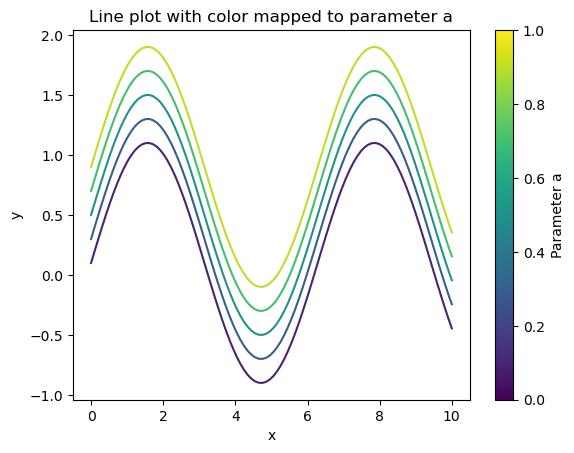

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create some example data
x = np.linspace(0, 10, 100)

# Initialize the figure and its axis
fig, ax = plt.subplots()

# Select a colormap
cmap = plt.get_cmap('viridis')

# Normalize between 0 and 1
norm = mcolors.Normalize(vmin=0, vmax=1)

# Plot multiple lines with different 'a' values
a_values = [0.1, 0.3, 0.5, 0.7, 0.9]
for a in a_values:
    y = np.sin(x) + a  # Slightly offset each line for better visibility
    color = cmap(norm(a))
    ax.plot(x, y, color=color, label=f'a={a:.1f}')

# Create a colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # We don't need to set array values as we're just using it for display purposes
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Parameter a')

# Set plot labels and show
ax.set_title('Line plot with color mapped to parameter a')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [ ]:
ls = [5,5,4,2,8,6,5,4]
np.unique(ls)

In [25]:
36*1e6 * 2440000**3

5.22964224e+26

In [11]:
10**9*2.2*np.pi*(2e-6)**2

0.02764601535159018

In [14]:
500e3/R_M

0.20491803278688525

In [7]:
Pxx=1
pxx=2

In [9]:
pxx

2

In [1]:
print("ts")

ts
